In [2]:
import numpy as np
import scipy
import scipy.stats

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim


# add paths to access shared code
import sys
sys.path.append("..")
sys.path.append("../scripts/")

# import library implementing models
import neuroprob as nprb
from neuroprob import utils

# import utility code for model building/training/loading
import lib
import HDC

# get GPU device if available
gpu_dev = 1
dev = utils.pytorch.get_device(gpu=gpu_dev)

# use custom plotting settings
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.style.use('../report_plots/report.mplstyle')

# useful colormap
white = '#ffffff'
red = '#ff0000'
blue = '#0000ff'
weight_map = utils.plot.make_cmap([blue, white, red], 'weight_map')


import warnings
warnings.simplefilter('ignore')

PyTorch version: 1.13.1+cu117
Using device: cuda:1


# Figure 16

In [2]:
mice_sessions = {
    'Mouse12': ['120806'],
    'Mouse17': ['130125', '130128', '130131', '130202', '130203'],
    'Mouse20': ['130514', '130515', '130516', '130517'],
    'Mouse24': ['131213', '131217', '131218'],
    'Mouse25': ['140124', '140128', '140129'],
    'Mouse28': ['140310']
} 

phase = 'wake'
subset = 'hdc'

bin_size = 160  # ms
single_spikes = False

delay = 0
batch_size = 1000  # size of time segments of each batch in dataset below
cv_run = -1


checkpoint_dir = '/scratches/ramanujan_2/vn283/HDC_PartIII/checkpoint/'
data_dir = '/scratches/ramanujan_2/vn283/HDC_PartIII/preprocessed/'

mouse_id = 'Mouse12'
session_id = 120806
phase = 'wake'
subset = 'nonhdc'

bin_size = 160  # ms
single_spikes = False

delay = 0
batch_size = 1000  # size of time segments of each batch in dataset below
cv_run = -1


checkpoint_dir = '/scratches/ramanujan_2/vn283/HDC_PartIII/checkpoint/'
data_dir = '/scratches/ramanujan_2/vn283/HDC_PartIII/preprocessed/'

In [3]:
basis_mode = 'ec'
C=3
hd_sweep = torch.linspace(0, 2*np.pi, 100)
angles = np.linspace(0, 360, hd_sweep.shape[-1])

tc_rates = np.empty((0, 100))  # we have 6 covariates, so 6 features
SSIs = np.empty((0, 100))
tc_FFs = np.empty((0, 100))
SSIs_poisson = np.empty((0,100))

label_hdc = np.empty((0,))

batch_size=600

for mouse_id in mice_sessions.keys():
    for session_id in mice_sessions[mouse_id]:
        for subset in ['nonhdc', 'hdc']:
            dataset_dict = HDC.get_dataset(mouse_id, session_id, phase, subset, bin_size, 
                                               single_spikes, path=data_dir)
            model_dict = {
                            'seed': 123, 
                            'll_mode': f'U-{basis_mode}-{C}',  # stands for universal count model with exponential-quadratic expansion and C = 3
                            'filt_mode': '',  # GLM couplings
                            'map_mode': 'svgp-64',  # a sparse variational GP mapping with 64 inducing points
                            'x_mode': 'hd-omega-speed-x-y-time',  # observed covariates (behaviour)
                            'z_mode': '',  # latent covariates
                            'hist_len': 0, 
                            'folds': 5, 
                            'delays': [0], 
                            'neurons': dataset_dict['neurons'], 
                            'max_count': dataset_dict['max_count'], 
                            'bin_size': dataset_dict['bin_size'], 
                            'tbin': dataset_dict['tbin'], 
                            'model_name': dataset_dict['name'], 
                            'tensor_type': torch.float, 
                            'jitter': 1e-4, 
                        }

            modelfit, training_results, fit_set, validation_set = lib.models.load_model(
                    checkpoint_dir, model_dict, dataset_dict, HDC.enc_used, 
                    delay, cv_run, batch_size, gpu_dev)

            rcov = dataset_dict['covariates']
            sweep = hd_sweep[None, :]
            rcov_matrix = [torch.tensor(rcov[k]) for k in rcov.keys()]
            units_used = dataset_dict['neurons']

            covariates=hd_sweep[None, None, :, None]
            with torch.no_grad():
                    P_mc = lib.helper.marginalized_P(
                    modelfit, sweep, [list(rcov.keys()).index('hd')],
                                                    rcov_matrix, batch_size, list(range(units_used)),
                                                    MC=30, skip=3)  # predictive posterior
            P_mc = P_mc.cpu()

            K = P_mc.shape[-1]
            counts = torch.arange(K)

            hd_mean = (counts[None, None, None, :] * P_mc).sum(-1)  # (MC, neurons, steps)
            hd_rate = hd_mean / dataset_dict['tbin']  # in units of Hz
            hd_var = (counts[None, None, None, :]**2 * P_mc).sum(-1) - hd_mean**2 
            hd_FF = hd_var / (hd_mean + 1e-12)

            [hd_mean] = utils.signal.percentiles_from_samples(hd_mean, [0.5])
            [hd_rate] = utils.signal.percentiles_from_samples(hd_rate, [0.5])
            [hd_FF] = utils.signal.percentiles_from_samples(hd_FF, [0.5])

            prior = np.ones(P_mc.shape[2]) / P_mc.shape[2]
            posterior = P_mc * prior[None, None, :, None]
            norm_const = torch.sum(posterior, axis=2)
            posterior = posterior / norm_const[:, :, None, :]
            i_sp = np.log2(P_mc.shape[2]) + torch.sum(posterior * np.nan_to_num(torch.log2(posterior), neginf=0.0), axis=2)
            SSI = torch.sum(P_mc * i_sp[:, :, None, :], axis=3)

            [SSI] = utils.signal.percentiles_from_samples(SSI.float(), [0.5])

            ks = np.arange(0, K)
            P_poisson = np.empty((P_mc.shape[1], P_mc.shape[2], P_mc.shape[3]))
            for i, k in enumerate(ks):
                P_poisson[:,:,i] = scipy.stats.poisson.pmf(k=k, mu=(hd_mean))
            posterior_poisson = P_poisson * prior[None, :, None]
            norm_const_poisson = np.sum(posterior_poisson, axis=1)
            posterior_poisson = posterior_poisson / norm_const_poisson[:, None, :]
            i_sp_poisson = np.log2(P_poisson.shape[1]) + np.sum(posterior_poisson * np.nan_to_num(np.log2(posterior_poisson), neginf=0.0), axis=1)
            SSI_poisson = np.sum(P_poisson * i_sp_poisson[:, None, :], axis=2)

            tc_rates = np.concatenate((tc_rates, hd_rate), axis=0)
            tc_FFs = np.concatenate((tc_FFs, hd_FF), axis=0)
            SSIs = np.concatenate((SSIs, SSI), axis=0)
            SSIs_poisson = np.concatenate((SSIs_poisson, SSI_poisson), axis=0)

            if subset == 'hdc':
                label_hdc = np.concatenate((label_hdc, np.ones(dataset_dict['neurons'])))
            else:
                label_hdc = np.concatenate((label_hdc, np.zeros(dataset_dict['neurons'])))


units:  85  hdc units:  22
99units:  85  hdc units:  22
99units:  21  hdc units:  2
99units:  21  hdc units:  2
99units:  46  hdc units:  7
99units:  46  hdc units:  7
99units:  50  hdc units:  7
99units:  50  hdc units:  7
99units:  55  hdc units:  5
99units:  55  hdc units:  5
99units:  59  hdc units:  7
99units:  59  hdc units:  7
99units:  11  hdc units:  2
99units:  11  hdc units:  2
99units:  13  hdc units:  4
99units:  13  hdc units:  4
99units:  17  hdc units:  4
99units:  17  hdc units:  4
99units:  22  hdc units:  6
99units:  22  hdc units:  6
99units:  28  hdc units:  5
99units:  28  hdc units:  5
99units:  40  hdc units:  11
99units:  40  hdc units:  11
99units:  43  hdc units:  11
99units:  43  hdc units:  11
99units:  36  hdc units:  10
99units:  36  hdc units:  10
99units:  32  hdc units:  5
99units:  32  hdc units:  5
99units:  33  hdc units:  11
99units:  33  hdc units:  11
99units:  56  hdc units:  14
99units:  56  hdc units:  14
99

In [14]:
#np.savez('../data/ssi_results.npz', tc_rates, tc_FFs, SSIs, SSIs_poisson, label_hdc)

loaded = np.load('../data/ssi_results.npz', allow_pickle=True)

tc_rates, tc_FFs, SSIs, SSIs_poisson, label_hdc = loaded[loaded.files[0]], loaded[loaded.files[1]], loaded[loaded.files[2]], loaded[loaded.files[3]], loaded[loaded.files[4]]

In [15]:
correlations_rates = np.empty((0,))
for ne in range(SSIs.shape[0]):
    C = np.corrcoef(SSIs[ne], tc_rates[ne])
    correlations_rates = np.append(correlations_rates, C[0,1])

correlations_ff = np.empty((0,))
for ne in range(SSIs.shape[0]):
    C = np.corrcoef(SSIs[ne], tc_FFs[ne])
    correlations_ff = np.append(correlations_ff, C[0,1])

correlations_ssi = np.empty((0,))
for ne in range(SSIs.shape[0]):
    C = np.corrcoef(SSIs[ne], SSIs_poisson[ne])
    correlations_ssi = np.append(correlations_ssi, C[0,1])

max_ssi = np.max(SSIs, axis=1)

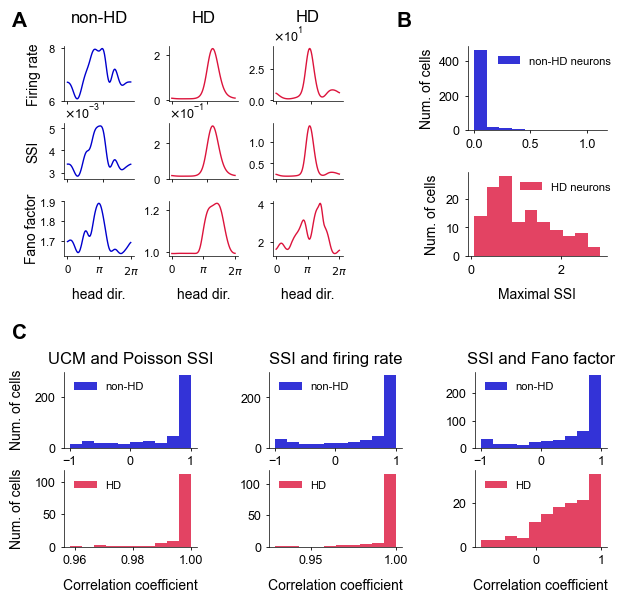

In [18]:
fig = plt.figure(figsize=(7, 6.5))
legendsize=10
angles = np.linspace(0, 360, tc_rates.shape[1])

colors = ['mediumblue', 'crimson']

gs00 = gridspec.GridSpec(2, 1, fig, hspace=0.6, height_ratios=[1.2,1])

gs_histograms = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs00[1], wspace=0.55)

gs0 = gridspec.GridSpecFromSubplotSpec(2,1, subplot_spec=gs_histograms[0], hspace=0.3)

ax = fig.add_subplot(gs0[0])
ax.hist(correlations_ssi[np.invert(label_hdc.astype(bool))], color=colors[0], label='non-HD', alpha=0.8)
ax.set_ylabel('Num. of cells')
ax.spines[['top', 'right']].set_visible(False)
ax.legend(prop={'size': 8}, frameon=False)
ax.set_title('UCM and Poisson SSI')

ax = fig.add_subplot(gs0[1])
ax.hist(correlations_ssi[label_hdc.astype(bool)], color = colors[1], label='HD', alpha=0.8)
ax.set_xlabel('Correlation coefficient')
ax.set_ylabel('Num. of cells')
ax.legend(prop={'size': 8}, frameon=False)
ax.spines[['top', 'right']].set_visible(False)

gs0 = gridspec.GridSpecFromSubplotSpec(2,1, subplot_spec=gs_histograms[1], hspace=0.3)

ax = fig.add_subplot(gs0[0])
ax.hist(correlations_rates[np.invert(label_hdc.astype(bool))], color=colors[0], label='non-HD', alpha=0.8)
ax.spines[['top', 'right']].set_visible(False)
ax.legend(prop={'size': 8}, frameon=False)
ax.set_title('SSI and firing rate')


ax = fig.add_subplot(gs0[1])
ax.hist(correlations_rates[label_hdc.astype(bool)], color = colors[1], label='HD', alpha=0.8)
ax.set_xlabel('Correlation coefficient')
ax.legend(prop={'size': 8}, frameon=False)
ax.spines[['top', 'right']].set_visible(False)

gs0 = gridspec.GridSpecFromSubplotSpec(2,1, subplot_spec=gs_histograms[2], hspace=0.3)

ax = fig.add_subplot(gs0[0])
ax.hist(correlations_ff[np.invert(label_hdc.astype(bool))], color=colors[0], label='non-HD', alpha=0.8)
ax.spines[['top', 'right']].set_visible(False)
ax.legend(prop={'size': 8}, frameon=False)
ax.set_title('SSI and Fano factor')

ax = fig.add_subplot(gs0[1])
ax.hist(correlations_ff[label_hdc.astype(bool)], color = colors[1], label='HD', alpha=0.8)
ax.set_xlabel('Correlation coefficient')
ax.legend(prop={'size': 8}, frameon=False)
ax.spines[['top', 'right']].set_visible(False)

# example neurons

gs01 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs00[0], width_ratios=[2,1], wspace=0.6)

gs1 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs01[0], wspace=0.5)

for i, ne in enumerate([6, 64, 65]):
    
    gs = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs1[i], hspace=0.4)

    ax = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1]), fig.add_subplot(gs[2])]

    if i == 0:
        ax[0].set_title('non-HD', pad=17)
    elif i == 1:
        ax[0].set_title('HD', pad=17)
    else:
        ax[0].set_title('HD', pad=-5)    

    if i==0:
        c = colors[0]
    else:
        c = colors[1]
    ax[0].plot(angles, tc_rates[ne], c=c)
    ax[1].plot(angles, SSIs[ne], c=c)
    ax[2].plot(angles, tc_FFs[ne], c=c)
    if i == 0:
        ax[0].set_ylabel('Firing rate', labelpad=5)
        ax[1].set_ylabel('SSI', labelpad=6)
        ax[2].set_ylabel('Fano factor', labelpad=0)
    ax[2].set_xlabel('head dir.')
    ax[2].set_xticks([0, 180, 360])
    ax[2].set_xticklabels(['0', '$\pi$', '$2\pi$'], fontsize=8)

    ax[0].set_xticklabels([])
    ax[1].set_xticklabels([])

    for j in [0,1,2]:
        ax[j].yaxis.get_major_formatter().set_scientific('%.1e')
        ax[j].yaxis.get_major_formatter().set_powerlimits((0,0))
        ax[j].yaxis.get_major_formatter().set_useMathText(True)
        ax[j].tick_params(axis='both', which='major', labelsize=8)



gs1 = gridspec.GridSpecFromSubplotSpec(2,1, subplot_spec=gs01[1], hspace=0.5)

ax = fig.add_subplot(gs1[0])
ax.hist(max_ssi[np.invert(label_hdc.astype(bool))], color=colors[0], label='non-HD neurons', alpha=0.8, bins=10)
ax.set_ylabel('Num. of cells', labelpad=3)
ax.legend(prop={'size': 8}, frameon=False, bbox_to_anchor=(1.1, 1))

ax = fig.add_subplot(gs1[1])
ax.hist(max_ssi[label_hdc.astype(bool)], color = colors[1], label='HD neurons', alpha=0.8, bins=10)
ax.set_xlabel('Maximal SSI')
ax.set_ylabel('Num. of cells', labelpad=5)
ax.legend(prop={'size': 8}, frameon=False, bbox_to_anchor=(1.1, 1))


fig.text(0.05, 0.91, 'A', transform=fig.transFigure, size=15, fontweight='bold')
fig.text(0.60, 0.91, 'B', transform=fig.transFigure, size=15, fontweight='bold')
fig.text(0.05, 0.43, 'C', transform=fig.transFigure, size=15, fontweight='bold')



fig.savefig("/homes/vn283/UCM-interpret/figures/ssi_correlations.pdf", format="pdf", bbox_inches="tight")
